# **Intel Image Classification**

## Aim of this project:
*     Learn PyTorch
*     Build a CNN that classifies 6 different categories of images
*     Test the Model

Process Steps:
After loading the dataset an exploratory analysis is conducted and a clean dataset is generated. We define our CNN which is a (small) Clone of VGG16, train it, test it and validate it on unseen images.

#### Table of Content:
* [1. Load Dataset](#chapter1) 
* [2. Exploratory Analysis](#chapter2)
* [3. Clean Trainingdata](#chapter3)
* [4. Define the CNN](#chapter4)
* [5. Perform Training and Cross Validation](#chapter5)
* [6. Test Model on Unseen Data](#chapter6)

  


Thanks to THẨM BÙI ĐÌNH who released his sourcecode for this Project to succeed. Any recommendations regarding a higher validation accuracy (e. g. Normalisation?) are welcome!

# **1. Load Dataset** <a class="anchor"  id="chapter1"></a>

In [1]:
#Define Directions
dir = "/kaggle/input/intel-image-classification"
train_dir = dir+'/seg_train/seg_train'
test_dir = dir+'/seg_test/seg_test'
val_dir =dir+'/seg_pred/seg_pred'

In [2]:
import torch as torch
from torchvision import datasets
from torchvision import transforms as T

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [3]:
#Define Transformations for explanatory analysis
from torchvision import transforms as T

train_transforms = T.Compose([T.ToTensor()])                                                                                                
test_transforms = T.Compose([T.ToTensor()])


#Load Datasets 
trainingdata = ImageFolderWithPaths(train_dir, transform=train_transforms) 
testdata = ImageFolderWithPaths(test_dir, transform=test_transforms) 

training_dataloader = torch.utils.data.DataLoader(trainingdata, batch_size=1, shuffle=True, pin_memory=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(testdata, batch_size=1, shuffle=True, pin_memory=True, num_workers=4)



print("data loaded") 

data loaded


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# **2. Exploratory Analysis** <a class="anchor"  id="chapter2"></a>

In [4]:
print("Training Dataset length is: {0}".format(len(training_dataloader)))
print("Testing Dataset length is: {0}".format(len(test_dataloader)))

image_1, label_1,_ = trainingdata[0]
image_7000, label_7000,_ = trainingdata[6999]

print("Image 1 format is: {0}".format(image_1.shape))

image_7000, label_7000, _= trainingdata[6999]
print("Another image format is: {0}".format(image_7000.shape))
print("There are {0} classes in total and they are named {1}".format(len(trainingdata.classes), trainingdata.class_to_idx))

Training Dataset length is: 14034
Testing Dataset length is: 3000
Image 1 format is: torch.Size([3, 150, 150])
Another image format is: torch.Size([3, 150, 150])
There are 6 classes in total and they are named {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [5]:
#Check image dimensions
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

#Plot images sizes
img_sizes = []
paths=[]
labels=[]
for batch in training_dataloader:
    X, y, path =  batch
    X = X.squeeze(0) #remove batch dim
    X = X.mean(0) #remove color dim
    img_sizes.append(tuple(X.shape))
    paths.append(path[0])
    labels.append(y.item())

df = pd.DataFrame(list(zip(img_sizes,paths,labels)), columns=["dims", "paths", "label"])
print(df.head())


         dims                                              paths  label
0  (150, 150)  /kaggle/input/intel-image-classification/seg_t...      1
1  (150, 150)  /kaggle/input/intel-image-classification/seg_t...      0
2  (150, 150)  /kaggle/input/intel-image-classification/seg_t...      0
3  (150, 150)  /kaggle/input/intel-image-classification/seg_t...      0
4  (150, 150)  /kaggle/input/intel-image-classification/seg_t...      0


   unique_values  counts
0     (150, 150)   13986
1     (113, 150)       7
2     (135, 150)       3
3     (111, 150)       3
4     (144, 150)       2
5     (146, 150)       2
6     (123, 150)       2
7     (143, 150)       2
8     (142, 150)       2
9     (108, 150)       2
10    (136, 150)       2
11    (134, 150)       2
12    (110, 150)       1
13    (124, 150)       1
14    (119, 150)       1
15    (105, 150)       1
16     (97, 150)       1
17    (133, 150)       1
18    (102, 150)       1
19    (120, 150)       1
20    (141, 150)       1
21    (145, 150)       1
22     (76, 150)       1
23     (81, 150)       1
24    (131, 150)       1
25    (100, 150)       1
26    (149, 150)       1
27    (103, 150)       1
28    (147, 150)       1
29    (140, 150)       1
30    (115, 150)       1


/tmp/ipykernel_23/2703449979.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x['unique_values'], rotation = 75)


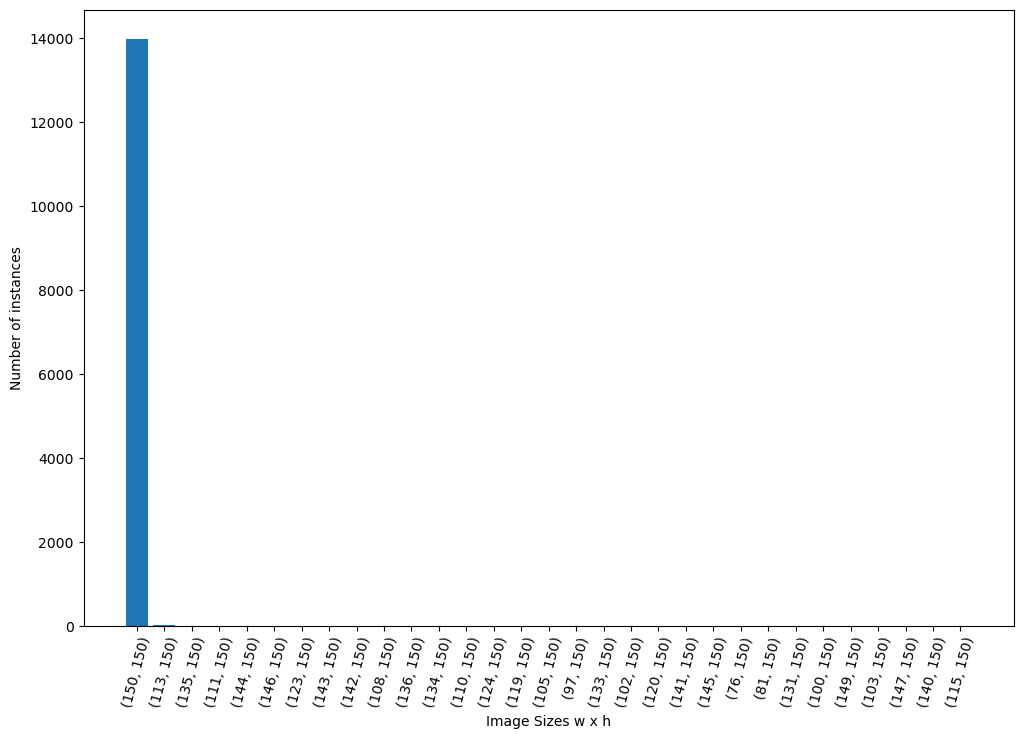

In [6]:
x = df["dims"].value_counts().rename_axis('unique_values').reset_index(name='counts')
fig, ax = plt.subplots(figsize = (12, 8))
ax.bar([str(i) for i in x.unique_values], x['counts'])
plt.xlabel("Image Sizes w x h")
plt.ylabel("Number of instances")
ax.set_xticklabels(x['unique_values'], rotation = 75)
print(x)
plt.show()


In [7]:
#Reload Dataset as img/path must be a tensor in dataloader
from torchvision.datasets import ImageFolder

train_transforms = T.Compose([T.Resize((150,150)),
                            T.ToTensor()])                                                                                                
    
test_transforms = T.Compose([T.Resize((150,150)),
                             T.ToTensor()])


trainingdata = ImageFolder(train_dir, transform=train_transforms) 
testdata = ImageFolder(test_dir, transform=test_transforms) 

print("Done")

Done


# **3. Clean Trainingdata** <a class="anchor"  id="chapter3"></a>

In [8]:
#Remove outliers
df = df.loc[(df['dims'] != (150, 150))] 

paths =  list(df["paths"])
labels = list(df["label"])

removelst = list(zip(paths, labels))

for x in removelst:
    trainingdata.imgs.remove(x)
    
print("outliers from training set deleted")   

outliers from training set deleted


In [9]:
print("New Trainingdata length is {0}:".format(len(trainingdata)))
#Reinit  Clean dataloader
training_dataloader = torch.utils.data.DataLoader(trainingdata, batch_size=1, shuffle=True, pin_memory=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(testdata, batch_size=1, shuffle=True, pin_memory=True, num_workers=4)
print("New Clean data loaded")

New Trainingdata length is 13986:
New Clean data loaded


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Text(0, 0.5, 'Number of training instances')

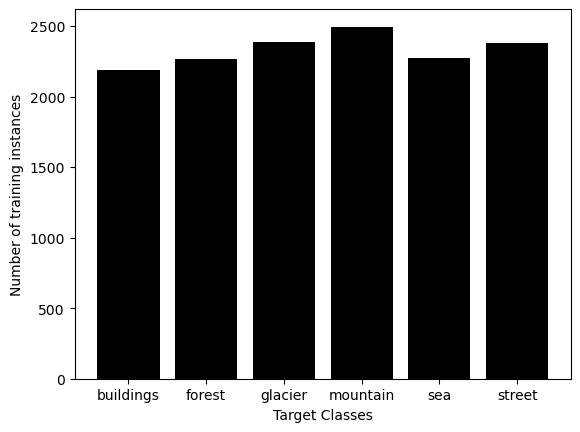

In [10]:
#Plot times every class appears
classes = []
for image, label in enumerate(training_dataloader, 0):
    _, y = label 
    classes.extend(y.tolist())
    

colors = "black"
#'red','green','blue','purple', 'black','orange'
     
#Calculating the unique classes and the respective counts and plotting them
unique, counts = np.unique(classes, return_counts=True)
names = list(trainingdata.class_to_idx.keys())
plt.bar(names, counts, color=colors)
plt.xlabel("Target Classes")
plt.ylabel("Number of training instances")

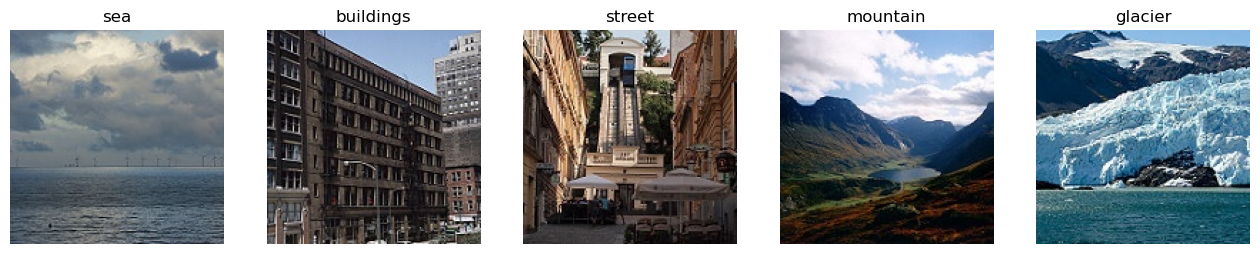

In [11]:
#Plot images 
from matplotlib.pyplot import figure

def plot_images (dataloader,image_number):    
    count=0
    figure, axis = plt.subplots(1, image_number+1, figsize=(16,8))
    #batchsize 1
    for img, lbl in dataloader:
        axis[count].imshow(img[0].permute(1, 2, 0))
        axis[count].set_title(trainingdata.classes[lbl.item()])
        axis[count].axis("off")
        if count == image_number:
            break
        else:
            count += 1
            
plot_images(training_dataloader, 4)
    

# **4. Define the CNN** <a class="anchor"  id="chapter4"></a>

In [12]:
# Create the CNN (Miniclone from VGG16-Architecture -->  https://iq.opengenus.org/vgg16/)
import torch.nn as nn

class VGG16Clone(nn.Module):
    def __init__(self):
        super(VGG16Clone, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Flatten(),
            nn.Linear(512 *9  * 9, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 6)
        )
    
    def forward(self, img):
        output = self.model(img)
        return output

In [13]:
model = VGG16Clone()
model

VGG16Clone(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1),

# **5. Perform Training and Cross Validation** <a class="anchor"  id="chapter5"></a>

In [14]:
# Calculate accuracy
def calcAccuracy(scores, label):
    _, prediction = torch.max(scores, dim=1)
    return torch.tensor(torch.sum(prediction == label).item()/len(scores))

# Cross validate
def validate(validate_ds, model,softmax):
    validate_length = 0
    accuracy = 0
    for img, lbl, in validate_ds:
        scores = model(img)
        loss = softmax(scores, lbl)
        accuracy += calcAccuracy(scores, lbl)
        validate_length += 1
    accuracy /= validate_length
    return loss, accuracy

# Run the training and cross validation
def train(train_ds, validate_ds, no_epochs, optimizer, model):
    history = []
    softmax = nn.CrossEntropyLoss()
    for index in range(no_epochs):
        # Train
        for img, lbl,in train_ds:
            scores = model(img)
            loss = softmax(scores, lbl)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validate
        valid_loss, valid_acr = validate(validate_ds, model, softmax)
            
        # Print epoch record
        print(f"Epoch [{index + 1}/{no_epochs}] => loss: {loss}, val_loss: {valid_loss}, val_acc: {valid_acr}")
        history.append({"loss": loss,
                       "valid_loss": valid_loss,
                       "valid_acr": valid_acr
                       })
    return history

In [15]:
# Load dataset to GPU
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class GPUDataLoader():
    def __init__(self, ds, device):
        self.ds = ds
        self.device = device
    
    def __iter__(self):
        for batch in self.ds:
            yield to_device(batch, self.device)

In [16]:
# Initialize model and data before training
device = torch.device('cuda:0')
model = model.to(device)
train_ds = GPUDataLoader(training_dataloader, device)
test_ds = GPUDataLoader(test_dataloader, device)

print("Done")

Done


In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.000025)
no_epochs = 14
history = train(train_ds, test_ds, no_epochs, optimizer, model)

Epoch [1/14] => loss: 1.5651886463165283, val_loss: 0.0913534164428711, val_acc: 0.6796666383743286
Epoch [2/14] => loss: 3.2606756687164307, val_loss: 0.02907499112188816, val_acc: 0.7490000128746033
Epoch [3/14] => loss: 0.5485671758651733, val_loss: 0.00020632999076042324, val_acc: 0.7876666784286499
Epoch [4/14] => loss: 0.31439098715782166, val_loss: 0.59758460521698, val_acc: 0.8176666498184204
Epoch [5/14] => loss: 1.0742729902267456, val_loss: 0.14330445230007172, val_acc: 0.828000009059906
Epoch [6/14] => loss: 2.0791501998901367, val_loss: 0.0232671108096838, val_acc: 0.8356666564941406
Epoch [7/14] => loss: 0.0042633600533008575, val_loss: 0.0037854695692658424, val_acc: 0.8343333601951599
Epoch [8/14] => loss: 1.2511926889419556, val_loss: 0.0018322361866012216, val_acc: 0.8463333249092102
Epoch [9/14] => loss: 0.03697311878204346, val_loss: 0.06718865782022476, val_acc: 0.8569999933242798
Epoch [10/14] => loss: 0.24317044019699097, val_loss: 7.319182623177767e-05, val_acc:

In [18]:
history

[{'loss': tensor(1.5652, device='cuda:0', grad_fn=<NllLossBackward0>),
  'valid_loss': tensor(0.0914, device='cuda:0', grad_fn=<NllLossBackward0>),
  'valid_acr': tensor(0.6797)},
 {'loss': tensor(3.2607, device='cuda:0', grad_fn=<NllLossBackward0>),
  'valid_loss': tensor(0.0291, device='cuda:0', grad_fn=<NllLossBackward0>),
  'valid_acr': tensor(0.7490)},
 {'loss': tensor(0.5486, device='cuda:0', grad_fn=<NllLossBackward0>),
  'valid_loss': tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>),
  'valid_acr': tensor(0.7877)},
 {'loss': tensor(0.3144, device='cuda:0', grad_fn=<NllLossBackward0>),
  'valid_loss': tensor(0.5976, device='cuda:0', grad_fn=<NllLossBackward0>),
  'valid_acr': tensor(0.8177)},
 {'loss': tensor(1.0743, device='cuda:0', grad_fn=<NllLossBackward0>),
  'valid_loss': tensor(0.1433, device='cuda:0', grad_fn=<NllLossBackward0>),
  'valid_acr': tensor(0.8280)},
 {'loss': tensor(2.0792, device='cuda:0', grad_fn=<NllLossBackward0>),
  'valid_loss': tensor(0.0233

In [19]:
train_loss = []
valid_loss = []
valid_acr = []
for x in history:
    train_loss.append(x["loss"].item())
    valid_loss.append(x["valid_loss"].item())
    valid_acr.append(x["valid_acr"].item())
    
epochs = np.arange(no_epochs)

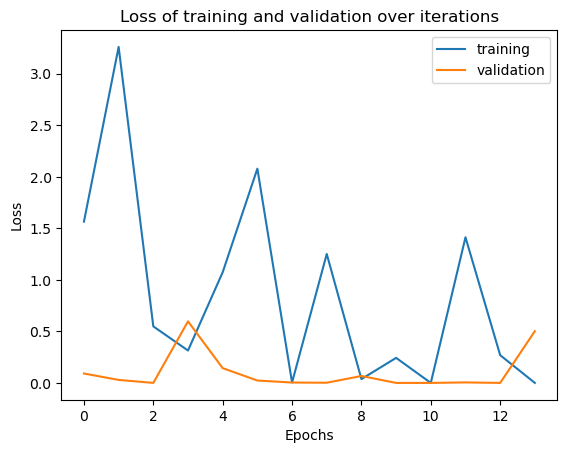

In [20]:
plt.plot(epochs, train_loss)
plt.plot(epochs, valid_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss of training and validation over iterations")
plt.legend(["training", "validation"])
plt.show()

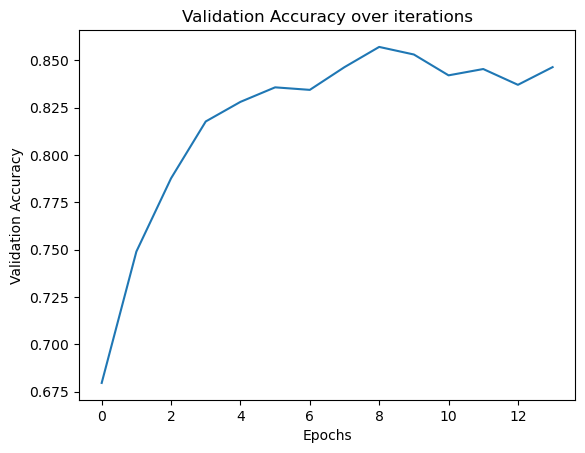

In [21]:
plt.plot(epochs, valid_acr)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over iterations")
plt.show()

# **6. Test Model on Unseen Data** <a class="anchor"  id="chapter6"></a>

In [22]:
import os

validationimages = []

transform = T.Compose([
    T.ToTensor(),
    T.Resize((150, 150))
])
for i in os.listdir(val_dir):
    img = plt.imread(val_dir + "/" + i).copy()
    validationimages.append(transform(img))


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [23]:
validation_ds = torch.utils.data.DataLoader(validationimages, pin_memory=True, num_workers=8)
validation_ds = GPUDataLoader(validation_ds, device)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


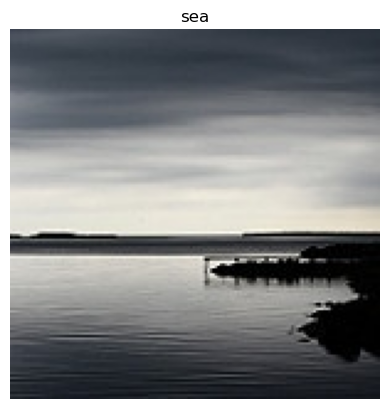

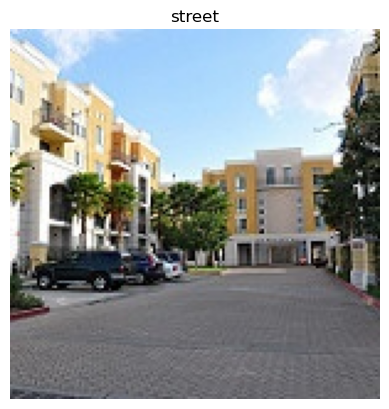

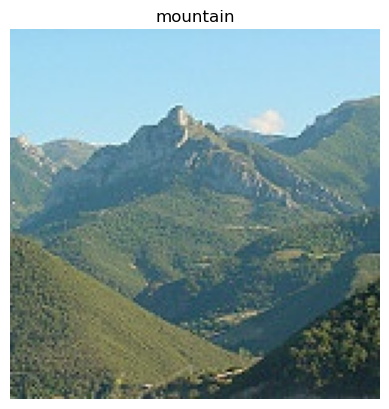

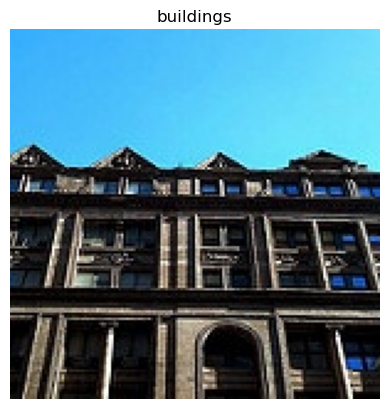

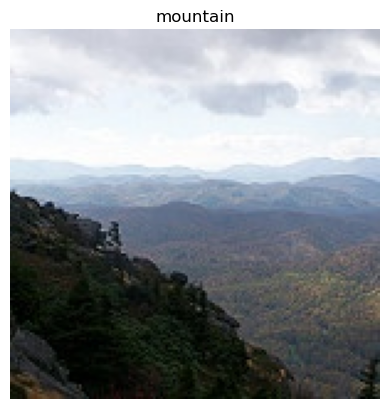

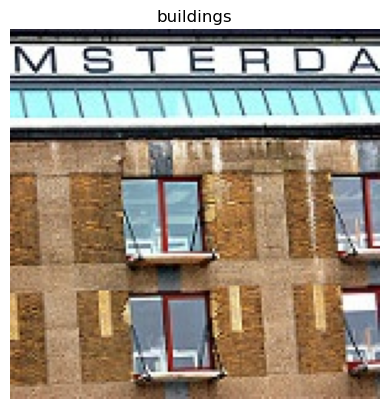

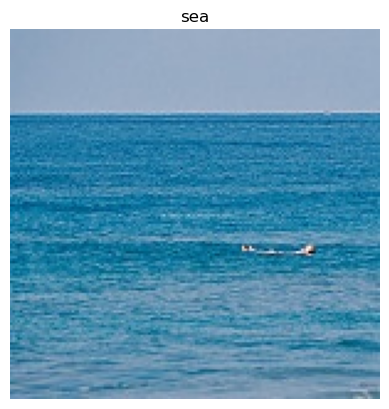

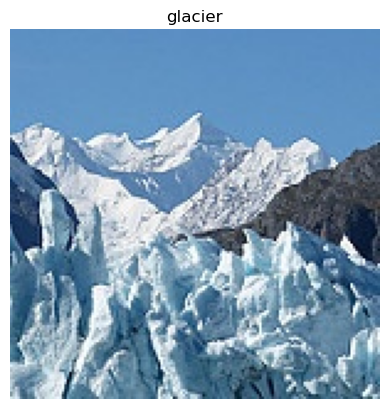

In [24]:
predictions = []
count = 0
for img in validation_ds:
    scores = model(img)
    _, prediction = torch.max(scores, dim=1)
    predictions.append(prediction.to('cpu').numpy())
    count += 1
    if count == 10:
        break
    
predicted_classes = [trainingdata.classes[x.item()] for x in predictions]

count = 0
for img in validation_ds:
    plt.imshow(img[0].to('cpu').permute(1, 2, 0))
    plt.title(predicted_classes[count])
    plt.axis("off")
    plt.show()
    count += 1
    if count == 8:
        break